# Tutorial — Problema de difusión 2D con condiciones Robin


## Modelo matemático

Dominio:

$$
\Omega = [0,1] \times [0,1]
$$

Ecuación gobernante (difusión pura):

$$
\nabla \cdot (\Gamma \nabla \phi) = 0
$$

Con:

$$
\Gamma = 1
$$

---

## Condiciones de borde

1. **Izquierda (x=0)**
$$
   \phi = 0
$$

2. **Derecha (x=1)**
$$
   \phi = 1
$$

3. **Inferior (y=0)**
   Robin:
$$
   -\frac{\partial \phi}{\partial n} + h \phi = h x
$$

4. **Superior (y=1)**
   Robin:
$$
   -\frac{\partial \phi}{\partial n} + h \phi = h x
$$

In [1]:
from fidelio import *
import numpy as np

## Malla

In [9]:
xl = 1
yl = 1

# Malla estructurada 8x8
nx = ny = 8
x = np.linspace(0.0, xl, nx)
y = np.linspace(0.0, yl, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

# Triangulación
tess = Tessellation(points)

mesh = MeshFVM(tess)
mesh.compute_fvm_geometry()

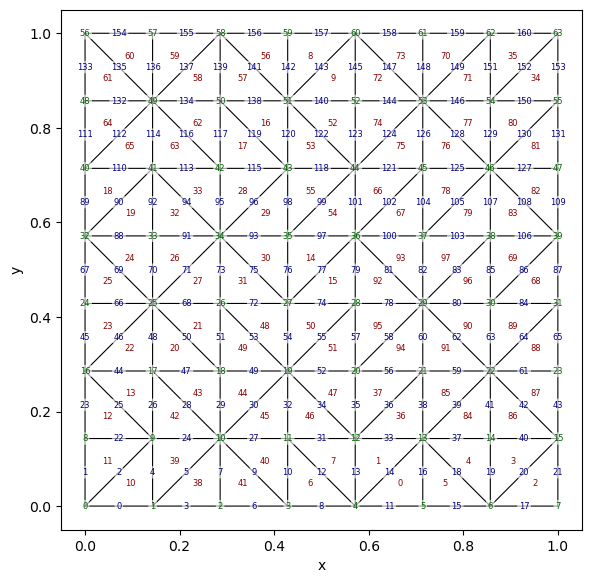

In [10]:
mesh.plot_topology(
    element_color = "darkred",
    face_color = "navy",
    node_color = "darkgreen",
    element_size = 6,
    face_size = 6,
    node_size = 6,
    figsize = (6, 6)
)

## Formulación de problema

In [4]:
p = FVMProblem(mesh)
p.initialize_phi(0.)
p._update_gradients()

def my_gamma(p):
    return np.full(p.Ne, 1.0)

p.gamma_function = my_gamma

p.initialize_gamma()
p.compute_diffusion_coefficients()

## Condiciones de borde

In [5]:
tol = 1e-6
face_centers = np.array([f.center for f in p.mesh.faces])

left_bound = np.where(np.abs(face_centers[:, 0]) < tol)[0]
right_bound = np.where(np.abs(face_centers[:, 0] - xl) < tol)[0]
down_bound = np.where(np.abs(face_centers[:, 1]) < tol)[0]
up_bound = np.where(np.abs(face_centers[:, 1] - yl) < tol)[0]

bounds = {
    "left_bound"  : left_bound,
    "right_bound" : right_bound,
    "down_bound"  : down_bound,
    "up_bound"    : up_bound
}

p.create_boundary_patches(bounds)

In [6]:
def my_boundary_sources(p):

    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)

    # =====================================================
    # 1) Dirichlet izquierda: phi = 0
    # =====================================================
    patch = p.left_bound

    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm

    Sp[patch.cells] += coeff
    Sc[patch.cells] += 0.0


    # =====================================================
    # 2) Dirichlet derecha: phi = 1
    # =====================================================
    patch = p.right_bound

    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm

    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 1.0


    # =====================================================
    # 3) Robin inferior:  -dphi/dn + h phi = h x
    # =====================================================
    h_coeff = 6.0

    patch = p.down_bound

    # Centros de cara
    face_centers = np.array(
        [p.mesh.faces[i].center for i in patch.faces]
    )

    x_faces = face_centers[:, 0]
    Af = patch.Sf_norm

    g = h_coeff * x_faces

    Sc[patch.cells] += g * Af
    Sp[patch.cells] += h_coeff * Af


    # =====================================================
    # 4) Robin superior:  -dphi/dn + h phi = h x
    # =====================================================
    patch = p.up_bound

    face_centers = np.array(
        [p.mesh.faces[i].center for i in patch.faces]
    )

    x_faces = face_centers[:, 0]
    Af = patch.Sf_norm

    g = h_coeff * x_faces

    Sc[patch.cells] += g * Af
    Sp[patch.cells] += h_coeff * Af


    return Sc, Sp

## Solución

In [7]:
p.boundary_sources_function = my_boundary_sources
p.calculate_boundary_sources()
p.assemble_system()
p.solve()

problem solved...


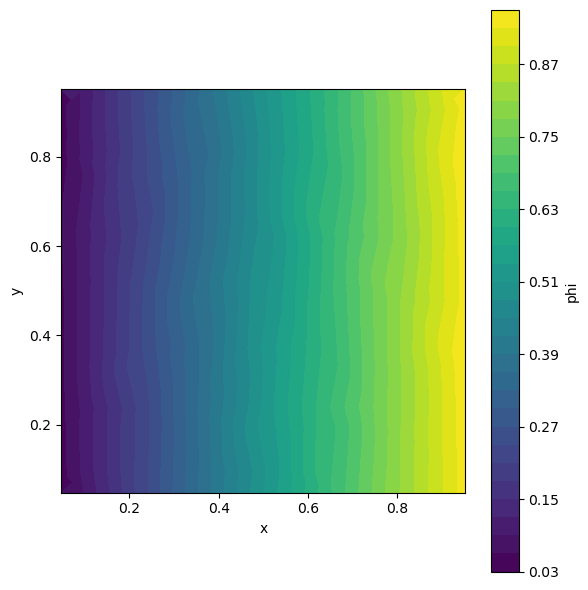

In [11]:
plot_phi_contours(
    p,
    field="cell",
    levels = 30,
    include_internal_faces=False,
    include_boundary_faces=True,
    show_contour_lines=False,
    figsize = (6, 6)
)

## Validación

In [17]:
def run_robin_case(nx):

    xl = yl = 1.0

    x = np.linspace(0.0, xl, nx)
    y = np.linspace(0.0, yl, nx)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.ravel(), Y.ravel()))

    tess = Tessellation(points)
    mesh = MeshFVM(tess)
    mesh.compute_fvm_geometry()

    p = FVMProblem(mesh)
    p.initialize_phi(0.)
    p._update_gradients()

    # Gamma constante
    def my_gamma(p):
        return np.ones(p.Ne)

    p.gamma_function = my_gamma
    p.initialize_gamma()
    p.compute_diffusion_coefficients()

    # ----------------------------
    # Boundary detection
    # ----------------------------
    tol = 1e-8
    face_centers = np.array([f.center for f in p.mesh.faces])

    left  = np.where(np.abs(face_centers[:,0]) < tol)[0]
    right = np.where(np.abs(face_centers[:,0] - xl) < tol)[0]
    down  = np.where(np.abs(face_centers[:,1]) < tol)[0]
    up    = np.where(np.abs(face_centers[:,1] - yl) < tol)[0]

    bounds = {
        "left_bound"  : left,
        "right_bound" : right,
        "down_bound"  : down,
        "up_bound"    : up
    }

    p.create_boundary_patches(bounds)

    # ----------------------------
    # Boundary sources
    # ----------------------------
    def my_boundary_sources(p):

        Sc = np.zeros(p.Ne)
        Sp = np.zeros(p.Ne)

        # Dirichlet izquierda: phi = 0
        patch = p.left_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += 0.0

        # Dirichlet derecha: phi = 1
        patch = p.right_bound
        gamma = p.Gamma_f[patch.faces]
        coeff = gamma * patch.Sf_norm / patch.dCf_norm
        Sp[patch.cells] += coeff
        Sc[patch.cells] += coeff * 1.0

        # Robin arriba y abajo
        h_coeff = 6.0

        for patch in [p.down_bound, p.up_bound]:

            face_centers = np.array(
                [p.mesh.faces[i].center for i in patch.faces]
            )

            x_faces = face_centers[:, 0]
            Af = patch.Sf_norm
            g = h_coeff * x_faces

            Sc[patch.cells] += g * Af
            Sp[patch.cells] += h_coeff * Af  # revisar signo según ensamblaje

        return Sc, Sp

    p.boundary_sources_function = my_boundary_sources
    p.calculate_boundary_sources()

    # ----------------------------
    # Solve
    # ----------------------------
    p.assemble_system()
    p.solve()

    # ----------------------------
    # Error
    # ----------------------------
    centroids = np.array([c.centroid for c in p.mesh.elements])
    phi_exact = centroids[:,0]  # phi = x

    error = p.phi_C - phi_exact
    L2 = np.sqrt(np.mean(error**2))

    return L2, p.Ne, p


In [18]:
resolutions = [8, 12, 16, 24, 32, 48, 64]
errors = []
n_cells = []

for n in resolutions:
    print(f"Running {n}x{n} ...")
    L2, Ne, p_ = run_robin_case(n)
    errors.append(L2)
    n_cells.append(Ne)

errors = np.array(errors)
n_cells = np.array(n_cells)
h = 1.0 / (np.array(resolutions) - 1)


Running 8x8 ...
problem solved...
Running 12x12 ...
problem solved...
Running 16x16 ...
problem solved...
Running 24x24 ...
problem solved...
Running 32x32 ...
problem solved...
Running 48x48 ...
problem solved...
Running 64x64 ...
problem solved...


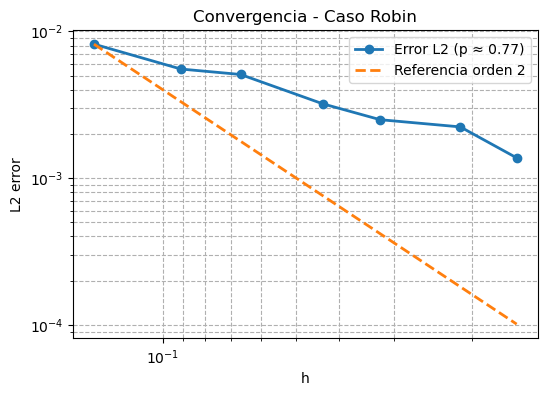

Orden estimado = 0.7694640759482526


In [19]:
p_fit = np.polyfit(np.log(h), np.log(errors), 1)
order_estimated = p_fit[0]

ref_order = 2
C_ref = errors[0] / (h[0]**ref_order)
ref_line = C_ref * h**ref_order

plt.figure(figsize=(6, 4))
plt.loglog(h, errors, 'o-', linewidth=2,
           label=f'Error L2 (p ≈ {order_estimated:.2f})')

plt.loglog(h, ref_line, '--', linewidth=2,
           label='Referencia orden 2')

plt.gca().invert_xaxis()
plt.xlabel("h")
plt.ylabel("L2 error")
plt.title("Convergencia - Caso Robin")
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

print("Orden estimado =", order_estimated)


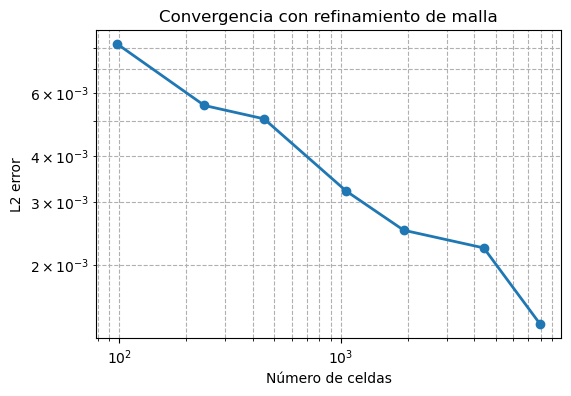

In [20]:
plt.figure(figsize=(6, 4))
plt.loglog(n_cells, errors, 'o-', linewidth=2)

plt.xlabel("Número de celdas")
plt.ylabel("L2 error")
plt.title("Convergencia con refinamiento de malla")
plt.grid(True, which='both', linestyle='--')
plt.show()